# Supervised learning models to predicting football matches outcomes

### Notebook by [Martim Pinto da Silva](https://github.com/motapinto), [Luis Ramos](https://github.com/luispramos), [Francisco Gonçalves](https://github.com/kiko-g)
#### Supported by [Luis Paulo Reis](https://web.fe.up.pt/~lpreis/)
#### [Faculdade de Engenharia da Universidade do Porto](https://sigarra.up.pt/feup/en/web_page.inicial)

#### It is recommended to [view this notebook in nbviewer](https://nbviewer.ipython.org/github.com/motapinto/football-classification-predications/blob/master/src/Supervised%20Learning%20Models.ipynb) for the best overall experience
#### You can also execute the code on this notebook using [Jupyter Notebook](https://jupyter.org/) or [Binder](https://mybinder.org/)(no local installation required)


## Table of contents
1. [Introduction](#Introduction)
2. [Required libraries and models](#Required-libraries-and-models)
3. [The problem domain](#The-problem-domain)
4. [Step 1: Data analysis](#Step-1:-Data-analysis)
5. [Step 2: Classification](#Step-2:-Classification)
6. [Step 3: Matches outcomes](#Step-3:-Matches-outcomes)
7. [Interpretation and Evaluation](#)
8. [Conclusion](#Conclusion)
9. [Resources](#Resources)

## Introduction
[go back to the top](#Table-of-content)
adasd
asd

## Required libraries and models
[go back to the top](#Table-of-content)

### Libraries
If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

**NumPy**: Provides a fast numerical array structure and helper functions.

**pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.

**scikit-learn**: The essential Machine Learning package, for a variaty of supervised learning models, in Python.

**tensorflow**: The essential Machine Learning package, for deep learning, in Python.

**matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.

### Models
Regarding the supervised learning models, we are using [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), [Nearest Neighbors](), [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html), and [Deep Learning Neural Networks](https://keras.io/guides/sequential_model/)


In [263]:
# Primary libraries
from time import time
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# Neural Networks
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
# Measures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder  

## The problem domain
[go back to the top](#Table-of-content)

The first step to any data analysis project is to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task. The data analysis checklist has us answer a handful of questions to accomplish that, so let's work through those questions.

#### Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

> We are trying to design a predictive model capable of accurately predicting if the home team will either win, lose or draw, i.e., predict the outcome of football matche based on a set of measurements, including player ratings, team ratings, team average stats(possession, corners, shoots), team style(pressing, possession, defending, counter attacking, speed of play, ..) and team match history(previous games)

#### Did you define the metric for success before beginning?

> Let's do that now. Since we're performing classification, we can use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) — the fraction of correctly classified matches — to quantify how well our model is performing. Knowing that most bookkeepers predict matches with an accuracy of 50%, we will try to match or beat that value. We will also use a confusion matrix, and analyse the precision, recall and f1-score. 
    
#### Did you consider whether the question could be answered with the available data?",

> The data provided has information about more than 25k matches across multiple leagues. Even though the usability isn't great, after some processing and cleansing of the data, we will be able to predict matches with great confidence. To answer the question, yes, we have more than enough data to analyse football matches..

## Step 1: Data analysis

The first step we have, is to look at the data, and after extracting, analyse it. We know that most datasets can contain minor issues, so we have to search for  possible null or not defined values, and if so how do we proceed? Do we remove an entire row of a Dataframe? Maybe we just need to purify and substitute it's value? This analysis is done below.

Before analysing the data, we need to first extract it. For that we use multiple methods to have a cleaner code :smiley:

### Defining FIFA related methods

In [264]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.iloc[0]    


def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data


def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

### Defining matches related methods

In [265]:
''' Derives a label for a given match. '''
def get_match_outcome(match):
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    outcome = pd.DataFrame()
    outcome.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match outcome  
    if home_goals > away_goals:
        outcome.loc[0,'outcome'] = "Win"
    if home_goals == away_goals:
        outcome.loc[0,'outcome'] = "Draw"
    if home_goals < away_goals:
        outcome.loc[0,'outcome'] = "Defeat"

    #Return outcome        
    return outcome.loc[0]


''' Get the last x matches of a given team. '''
def get_last_matches(matches, date, team, x = 10):
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches
    
    
''' Get the last team stats of a given team. '''
def get_last_team_stats(team_id, date, team_stats):
    #Filter team stats
    all_team_stats = teams_stats[teams_stats['team_api_id'] == team_id]
           
    #Filter last stats from team
    last_team_stats = all_team_stats[all_team_stats.date < date].sort_values(by = 'date', ascending = False).iloc[0:1,:]
         
    #Return last matches
    return last_team_stats
    
    
''' Get the last x matches of two given teams. '''
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches


''' Get the goals[home & away] of a specfic team from a set of matches. '''
def get_goals(matches, team):
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    return total_goals


''' Get the goals[home & away] conceided of a specfic team from a set of matches. '''
def get_goals_conceided(matches, team):
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals


''' Get the number of wins of a specfic team from a set of matches. '''
def get_wins(matches, team):
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    return total_wins 


''' Create match specific features for a given match. '''
def get_match_features(match, matches, teams_stats, x = 10):
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
     # Gets home and away team_stats
    home_team_stats = get_last_team_stats(home_team, date, teams_stats);
    away_team_stats = get_last_team_stats(away_team, date, teams_stats);
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 5)
    matches_away_team = get_last_matches(matches, date, away_team, x = 5)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id
    
    #Create match features and team stats
    if(not home_team_stats.empty):
        result.loc[0, 'home_team_buildUpPlaySpeed'] = home_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'home_team_buildUpPlayPassing'] = home_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationPassing'] = home_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationCrossing'] = home_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'home_team_chanceCreationShooting'] = home_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'home_team_defencePressure'] = home_team_stats['defencePressure'].values[0]
        result.loc[0, 'home_team_defenceAggression'] = home_team_stats['defenceAggression'].values[0]
        result.loc[0, 'home_team_defenceTeamWidth'] = home_team_stats['defenceTeamWidth'].values[0]
    
    if(not away_team_stats.empty):
        result.loc[0, 'away_team_buildUpPlaySpeed'] = away_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'away_team_buildUpPlayPassing'] = away_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationPassing'] = away_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationCrossing'] = away_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'away_team_chanceCreationShooting'] = away_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'away_team_defencePressure'] = away_team_stats['defencePressure'].values[0]
        result.loc[0, 'away_team_defenceAggression'] = away_team_stats['defenceAggression'].values[0]
        result.loc[0, 'away_team_defenceTeamWidth'] = away_team_stats['defenceTeamWidth'].values[0]
    
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    #Return match features
    return result.loc[0]

''' Create and aggregate features and labels for all matches. '''
def get_features(matches, teams_stats, fifa, x = 10, get_overall = False):  
    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    #Get match features for all matches
    match_stats = matches.apply(lambda i: get_match_features(i, matches, teams_stats, x = 10), axis = 1)
    
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    #Create match outcomes
    outcomes = matches.apply(get_match_outcome, axis = 1)

    #Merges features and outcomes into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, outcomes, on = 'match_api_id', how = 'left')
    
    #Drop NA values
    features.dropna(inplace = True)
    
    #Return preprocessed data
    return features

### Extracting data from the database

In [266]:
with sqlite3.connect("../dataset/database.sqlite") as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    matches = pd.read_sql_query("SELECT * from Match limit 3200", con)
    team_attributes = pd.read_sql_query("SELECT distinct * from Team_Attributes",con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)
    
# player stats
#crosses = pd.read_csv("../dataset/cross_detail.csv")
#goals = pd.read_csv("../dataset/goal_detail.csv")
#shots_off = pd.read_csv("../dataset/shotoff_detail.csv")
#shots_on = pd.read_csv("../dataset/shoton_detail.csv")
#fouls_commited = pd.read_csv("../dataset/foulcommit_detail.csv")
# team stats
#possessions = pd.read_csv("../dataset/possession_detail.csv")
#corners = pd.read_csv("../dataset/corner_detail.csv")

### Team Stats - Team Attributes

In [267]:
teams_stats = team_attributes
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


Looking at the description of team attributes we can see that there are a lot of values missing from the column buildUpPlayDribbling, and all the other values seem to hae the right amout of rows. This means that there are a lot of values with 'Nan' on this column.

It's not ideal that we just drop those rows. Seems like the missing data on the column is systematic - all of the missing values are in the same column - this error could potentially bias our analysis

One way to deal with missing values is **mean imputation**. If we know that the values for a measurement fall in a certain range, we can fill in empty values with the average of that measure.


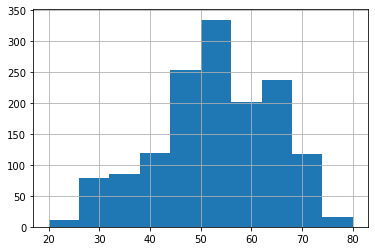

In [268]:
teams_stats['buildUpPlaySpeed'].hist();

We can see that most buildUpPlaySpeed values fall within the 45 - 68 range, so let's fill in these entries with the average measured buildUpPlaySpeed

In [269]:
build_up_play_speed_avg = teams_stats['buildUpPlaySpeed'].mean()
# mean imputation
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull()), 'buildUpPlayDribbling'] = build_up_play_speed_avg
# showing new values
teams_stats.loc[teams_stats['buildUpPlayDribbling'] == build_up_play_speed_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,52.462277,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,52.462277,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,52.462277,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,6,77,8485,2012-02-22 00:00:00,58,Balanced,52.462277,Little,62,Mixed,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,7,77,8485,2013-09-20 00:00:00,62,Balanced,52.462277,Little,45,Mixed,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover


In [270]:
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the buildUpPlayDribbling. After that, we decided to select only continuous data, i.e, select only columns that "store" numerical values that we will provide to the input of the supervised learning models.

In [271]:
teams_stats.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', 
    'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass',  
    'chanceCreationShootingClass','chanceCreationPositioningClass','defencePressureClass', 'defenceAggressionClass', 
    'defenceTeamWidthClass','defenceDefenderLineClass'], inplace = True, axis = 1)

teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,51.169373,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,5.889636,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,52.462277,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,52.462277,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,52.462277,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


### Team Stats - Shots
After cleaning the match data we need to consider adding some more stats to each match. We will start by adding the average of the number of shots per team. The number of shots consists on the sum of the shots on target and the shots of target. After merging all the information to teams_stats we have to analyse the data again.

In [272]:
shots_off = pd.read_csv("../dataset/shotoff_detail.csv")
shots_on = pd.read_csv("../dataset/shoton_detail.csv")
shots = pd.concat([shots_off[['match_id', 'team']], shots_on[['match_id', 'team']]])

total_shots = shots["team"].value_counts()
total_matches = shots.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_shots in total_shots.iteritems():
    n_matches = total_matches[index]
    avg_shots = n_shots / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_shots'] = avg_shots
    
teams_stats.loc[(teams_stats['avg_shots'].isnull())].head()

c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (0,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (1,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots
0,1,434,9930,2010-02-22 00:00:00,60,52.462277,50,60,65,55,50,55,45,NaN
1,2,434,9930,2014-09-19 00:00:00,52,48.000000,56,54,63,64,47,44,54,NaN
2,3,434,9930,2015-09-10 00:00:00,47,41.000000,54,54,63,64,47,44,54,NaN
3,4,77,8485,2010-02-22 00:00:00,70,52.462277,70,70,70,70,60,70,70,NaN
4,5,77,8485,2011-02-22 00:00:00,47,52.462277,52,53,48,52,47,47,52,NaN


As we can see, there are a lot of Nan values on the avg_shots column. This represents teams that did not have shots data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

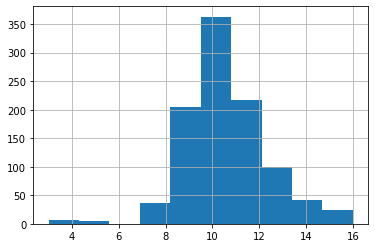

In [273]:
teams_stats['avg_shots'].hist();

We can see that most avg_shots values fall within the 7 - 14 range, so let's fill in these entries with the average measured avg_shots

In [274]:
shots_avg_team_avg = teams_stats['avg_shots'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_shots'].isnull()), 'avg_shots'] = shots_avg_team_avg
# showing new values
teams_stats.loc[teams_stats['avg_shots'] == shots_avg_team_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots
0,1,434,9930,2010-02-22 00:00:00,60,52.462277,50,60,65,55,50,55,45,10.579949
1,2,434,9930,2014-09-19 00:00:00,52,48.000000,56,54,63,64,47,44,54,10.579949
2,3,434,9930,2015-09-10 00:00:00,47,41.000000,54,54,63,64,47,44,54,10.579949
3,4,77,8485,2010-02-22 00:00:00,70,52.462277,70,70,70,70,60,70,70,10.579949
4,5,77,8485,2011-02-22 00:00:00,47,52.462277,52,53,48,52,47,47,52,10.579949


In [279]:
teams_stats.loc[(teams_stats['avg_shots'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_shots.

### Team Stats - Possession

We will now add another stat, the ball possession. One of the more important statistics to predict the match results. If we analyse the most dominating teams usually control the ball possession very easily. We can see first that the csv have repeated values for the ball possession, for each match, based on the elapsed time of the match. We need to remove all the values that do not refer to the 90 minutes mark of the elapsed time.

In [300]:
# possessions read, cleanup and merge
possessions_data = pd.read_csv("../dataset/possession_detail.csv")
#last_possessions = possessions_data.sort_values(by='elapsed', ascending=False).drop_duplicates(['match_id'])
last_possessions = possessions_data.loc[(possessions_data['elapsed'] == 90)]
last_possessions = last_possessions[['match_id', 'homepos', 'awaypos']]
last_possessions.describe()

,match_id,homepos,awaypos
count,5887.000000,5885.000000,5885.000000
mean,10079.772210,51.378760,48.621240
std,7329.908892,9.376235,9.376235
min,1729.000000,3.000000,20.000000
25%,3822.500000,45.000000,43.000000
50%,8369.000000,52.000000,48.000000
75%,13060.500000,57.000000,55.000000
max,24557.000000,80.000000,97.000000


After cleaning the possession data, and seeing that no data is missing, we need to merge that information with the team_stats Dataframe.

In [291]:
# get the ids of the home_team and away_team to be able to join with teams later
possessions = pd.DataFrame(columns=['team', 'possession', 'match'])
for index, row in last_possessions.iterrows():
    match = viable_matches.loc[viable_matches['id'] == row['match_id'], ['home_team_api_id', 'away_team_api_id']]
    if match.empty is True:
        continue
    hometeam = match['home_team_api_id'].values[0]
    awayteam = match['away_team_api_id'].values[0]
    possessions = possessions.append({'team': hometeam, 'possession': row['homepos'], 'match': row['match_id']}, ignore_index=True)
    possessions = possessions.append({'team': awayteam, 'possession': row['awaypos'], 'match': row['match_id']}, ignore_index=True)

possessions.head()

total_possessions = possessions.groupby(by=['team'])['possession'].sum()
total_matches = possessions.drop_duplicates(['team', 'match'])["team"].value_counts()

After cleaning the possession data, and seeing that no data is missing, we need to merge that information with the team_stats Dataframe.

In [290]:
for index, n_possession in total_possessions.iteritems():
    n_matches = total_matches[index]
    avg_shots = n_possession / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_possession'] = avg_shots

teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_possession
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,162.000000
mean,729.500000,17706.982167,9995.727023,52.462277,51.169373,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,49.811655
std,421.032659,39179.857739,13264.869900,11.545869,5.889636,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,2.960337
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,46.460526
25%,365.250000,110.000000,8457.750000,45.000000,52.462277,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,47.397059
50%,729.500000,485.000000,8674.000000,52.000000,52.462277,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,49.228571
75%,1093.750000,1900.000000,9904.000000,62.000000,52.462277,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,51.387097
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,56.428571


### Team Stats - Corners

In [295]:
corners_data = pd.read_csv("../dataset/corner_detail.csv")
corners = corners_data[['match_id', 'team']]
corners.describe()

c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,match_id,team
count,87839.000000,87753.000000
mean,10252.953301,9518.079416
std,7343.056413,9001.928028
min,1729.000000,1601.000000
25%,3718.000000,8535.000000
50%,8703.000000,8661.000000
75%,13125.000000,9875.000000
max,24557.000000,208931.000000


In [ ]:


corners = corners_data[['match_id', 'team']]

print ("Corners head\n", corners.head(), "\n")

total_corners = corners["team"].value_counts()
total_matches = corners.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_corners in total_shots.iteritems():
    n_matches = total_matches[index]
    avg_corners = n_corners / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_corners'] = avg_corners
    
teams_stats.describe()

### Matches
After cleaning the team attributes we must now look at the match data and analyse it once more

In [275]:
matches.describe()
viable_matches = matches

Looking at the match data we can see that most columns have 2622 values. This means we are analysing this number of matches from the database. We could test with all the matches(25k+) but if that were the case, then testing would take more than 1 hour. We can also see that some bookkeeper is missing. Having done a detailed analysis on it, we saw some inconsistencys and so we will not consider them.

In [276]:
viable_matches.drop(['B365H', 'B365D', 'B365A', 
                      'BWH', 'BWD', 'BWA', 
                      'IWH', 'IWD', 'IWA',  
                      'LBH', 'LBD', 'LBA',
                      'PSH', 'PSD', 'PSA',
                      'WHH', 'WHD', 'WHA',
                      'SJH', 'SJD', 'SJA',
                      'VCH', 'VCD', 'VCA', 
                      'GBH', 'GBD', 'GBA', 
                      'BSH', 'BSD', 'BSA'], 
                    inplace = True, axis = 1)

We also need to consider that some of these matches may not be on the team attributes that we cleaned earlier. In that case, we need to remove any matches that does not contain any team stats information, since **mean imputation** would't work in these case.

In [277]:
viable_matches = matches.dropna(inplace=False)

home_teams = viable_matches['home_team_api_id'].isin(teams_stats['team_api_id'].tolist())
away_teams = viable_matches['away_team_api_id'].isin(teams_stats['team_api_id'].tolist())
viable_matches = viable_matches[home_teams & away_teams]

viable_matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
count,1407.000000,1407.0,1407.0,1407.000000,1.407000e+03,1407.000000,1407.000000,1407.000000,1407.000000,1407.0,...,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000
mean,2469.941009,1729.0,1729.0,19.786780,7.472511e+05,9058.290689,9069.690832,1.563611,1.131485,1.0,...,40879.999289,34634.401564,34794.054726,40001.212509,45508.985075,45693.231699,41677.893390,39274.656006,38011.646766,36375.729211
std,424.046355,0.0,0.0,10.887242,1.957975e+05,725.236642,729.971137,1.323294,1.136700,0.0,...,36576.678429,24594.718396,27270.086441,35423.374226,39030.050032,37977.413744,33919.509706,33515.068807,32050.646743,22694.214844
min,1729.000000,1729.0,1729.0,1.000000,4.890420e+05,8191.000000,8191.000000,0.000000,0.000000,1.0,...,11736.000000,11736.000000,11736.000000,11736.000000,3520.000000,11496.000000,3520.000000,3512.000000,3520.000000,3520.000000
25%,2112.500000,1729.0,1729.0,11.000000,6.585765e+05,8528.000000,8549.000000,1.000000,0.000000,1.0,...,25925.000000,24211.000000,24216.000000,24408.000000,24435.000000,24738.500000,24663.500000,24664.000000,24698.000000,24741.000000
50%,2471.000000,1729.0,1729.0,20.000000,6.591800e+05,8655.000000,8655.000000,1.000000,1.000000,1.0,...,31306.000000,30617.000000,26777.000000,30739.000000,30895.000000,30839.000000,30631.000000,30892.000000,30843.000000,30853.000000
75%,2835.500000,1729.0,1729.0,29.000000,8.401985e+05,9879.000000,9879.000000,2.000000,2.000000,1.0,...,37266.000000,35554.000000,34193.000000,38834.000000,38807.000000,39109.000000,38556.500000,36012.000000,36012.000000,37166.000000
max,3200.000000,1729.0,1729.0,38.000000,1.026210e+06,10261.000000,10261.000000,9.000000,6.000000,1.0,...,287223.000000,202180.000000,202180.000000,414792.000000,281079.000000,282251.000000,414792.000000,282274.000000,414792.000000,242308.000000


In [278]:
fifa_data = get_fifa_data(viable_matches, player_attributes, None, data_exists = False)

KeyboardInterrupt: 

In [ ]:
# Creates features and labels based on the provided data
viables = get_features(viable_matches, teams_stats, fifa_data, 10, False)
inputs = viables.drop('match_api_id', axis=1)
outcomes = inputs.loc[:, 'outcome']

In [ ]:
# all features except outcomes
features = inputs.drop('outcome', axis=1)
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size = 0.2, shuffle = True, stratify = outcomes)

In [ ]:
# Training and Evaluating Models
def train_model(clf, X_train, y_train):
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    print ('Training took {} seconds'.format(end - start))
    
def predict_outcome(clf, X_test, y_test):
    start = time()
    y_predict = clf.predict(X_test)
    end = time()
    print ('Predictions took {} seconds'.format(end - start))
    print("Accuracy score for training set: ", metrics.accuracy_score(y_test, y_predict))
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    train_model(clf, X_train, y_train)
    predict_outcome(clf, X_test, y_test)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=101)
train_predict(clf, X_train, y_train, X_test, y_test)

In [ ]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', splitter='random', max_depth=5)
train_predict(clf, X_train, y_train, X_test, y_test)

In [ ]:
clf = SVC(coef0=5, kernel='poly')
train_predict(clf, X_train, y_train, X_test, y_test)

In [ ]:
clf = GaussianNB(var_smoothing=1.1)
train_predict(clf, X_train, y_train, X_test, y_test)

In [ ]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train)
y_test2 = le.fit_transform(y_test)
y_train2 = np_utils.to_categorical(y_train2)
y_test2 = np_utils.to_categorical(y_test2)

#clf = Sequential()
#clf.add(Dense(16, input_shape=(39,), activation='sigmoid'))
#clf.add(Dense(8, activation='sigmoid'))
#clf.add(Dense(1, activation='sigmoid'))

#print(clf.summary())


visible = Input(shape=(55,))
hidden1 = Dense(500, activation='relu')(visible)
hidden2 = Dense(100, activation='relu')(hidden1)
hidden3 = Dense(50, activation='relu')(hidden2)
output = Dense(3, activation='softmax')(hidden3)

clf = Model(inputs=visible, outputs=output)

#clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
clf.compile(optimizer='adagrad', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


clf.fit(X_train, y_train2, epochs=150, batch_size=313)

pred_train = clf.predict(X_train)
scores = clf.evaluate(X_train, y_train2, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test = clf.predict(X_test)
scores2 = clf.evaluate(X_test, y_test2, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    